In [17]:
import os
import shutil
import tensorflow as tf
from skimage import transform
import cv2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from keras.models import Model
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.layers import Input
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt

MODELS_DIR = os.path.abspath("C:/Projects/tensorflow/models")
MODEL_FILE_PATH = os.path.join(MODELS_DIR, "catsdogs_model.h5")
FULL_MODEL_FILE_PATH = os.path.join(MODELS_DIR, "full_catsdogs_model")
LOGS_DIR = os.path.abspath("C:/Projects/tensorflow/logs")
MODEL_LOGS_DIR = os.path.join(LOGS_DIR, "catsdogs_logs")
DATA_DIR = os.path.join("C:/Projects/tensorflow/training_data/PetImages")
X_FILE_PATH = os.path.join(DATA_DIR, "x.npy")
Y_FILE_PATH = os.path.join(DATA_DIR, "y.npy")
IMG_SIZE = 32
IMG_DEPTH = 3
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, IMG_DEPTH)

Extract Images

In [38]:
def extract_cats_dogs()->None:
    cats_dir = os.path.join(DATA_DIR, "Cat")
    dogs_dir = os.path.join(DATA_DIR, "Dog")
    
    dirs = [cats_dir, dogs_dir]
    class_names = ["cat", "dog"]
    
    for d in dirs:
        for f in os.listdir(d):
            if f.split(".")[-1] != "jpg":
                print(f"Removing file: {f}")
                os.remove(os.path.join(d, f))

    num_cats = len(os.listdir(cats_dir))
    num_dogs = len(os.listdir(dogs_dir))
    num_images = num_cats + num_dogs
    
    x = np.zeros(
        shape=(num_images, IMG_SIZE, IMG_SIZE, IMG_DEPTH),
        dtype=np.float32
    )
    y = np.zeros(
        shape=(num_images, ),
        dtype=np.float32
    )
    
    cnt = 0
    for d, class_name in zip(dirs, class_names):
        for f in os.listdir(d):
            img_file_path = os.path.join(d,f)
            try:
                img = cv2.imread(img_file_path, cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                x[cnt] = transform.resize(
                    image=img,
                    output_shape=IMG_SHAPE
                )
                if class_name == "cat":
                    y[cnt] = 1
                elif class_name == "dog":
                    y[cnt] = 0
                else:
                    print("Invalid class name!")
                cnt+=1
            except: # noqa: E722
                print(f"Image {f} cannot be read!")
                os.remove(img_file_path)
                
    #Dropping non-readable image idxs
    x = x[:cnt]
    y = y[:cnt]
    
    np.save(X_FILE_PATH, x)
    np.save(Y_FILE_PATH, y)

extract_cats_dogs()

Preprocessing

In [6]:
def get_dataset(num_classes: int) -> tuple[tuple[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]]:
    x = np.load(X_FILE_PATH)
    y = np.load(Y_FILE_PATH)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33)
    
    # Data Augmentation
    augment_size = 5_000
    image_gen = ImageDataGenerator(
        rotation_range=5,
        zoom_range=0.05,
        width_shift_range=0.08,
        height_shift_range=0.08
    )
    image_gen.fit(x_train, augment=True)
    rndm_idxs = np.random.randint(low=x_train.shape[0],high=None, size=augment_size)
    x_augmented = x_train[rndm_idxs].copy()
    y_augmented = y_train[rndm_idxs].copy()
    x_augmented = image_gen.flow(x_augmented, np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]
    x_train = np.concatenate((x_train, x_augmented))
    y_train = np.concatenate((y_train, y_augmented))
    
    y_train = to_categorical(y_train, num_classes=num_classes, dtype=np.float32)
    y_val = to_categorical(y_val, num_classes=num_classes, dtype=np.float32)
    y_test = to_categorical(y_test, num_classes=num_classes, dtype=np.float32)
    print (f"x shape: {x_train.shape}   y shape: {y_train.shape}")
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)


Get DATA

In [7]:
num_classes = 2
img_shape = (32, 32, 3)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = get_dataset(num_classes=num_classes)

x shape: (18370, 32, 32, 3)   y shape: (18370, 2)


In [13]:
def build_model(img_shape : tuple[int,int,int], num_classes: int, filters1: int, filters2: int,
                filters3: int, filters4: int, kernel1: int, kernel2: int, kernel3: int, kernel4: int,
                dense_layer: int, learning_rate: float, optimizer: tf.keras.optimizers.Optimizer) -> Model:
    
    img_input = Input(img_shape)
    x = Conv2D(filters=filters1, kernel_size=kernel1, padding = "same")(img_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=filters2, kernel_size=kernel2)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=filters3, kernel_size=kernel3)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(filters=filters4, kernel_size=kernel4)(x)
    x = Activation("relu")(x)
     
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=dense_layer)(x)
    x = Activation("relu")(x)
    x = Dense(units=num_classes)(x)
    y_pred = Activation("softmax")(x)
    
    model = Model(
        inputs=[img_input],
        outputs=[y_pred]
    )
    
    model.compile(loss="categorical_crossentropy",
              optimizer=optimizer(learning_rate=learning_rate),
              metrics=["accuracy"])
    
    return model

Build Model with GridSearch

Train the Model

0.Combination Run:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_13 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 activation_14 (Activation)  (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                        

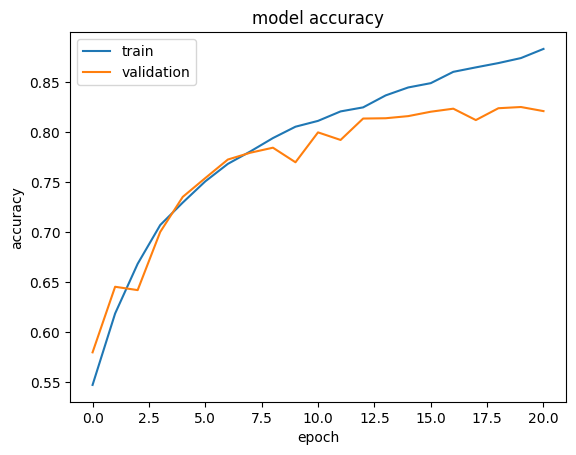

In [15]:
param_grid = {
    "filters1": [32], "filters2": [32], "filters3": [64], "filters4": [64],
    "kernel1": [3], "kernel2": [3], "kernel3": [3],
    "kernel4": [3], "dense_layer": [32], "learning_rate": [0.001],
    "optimizer": [Adam]
}

results = {
    "best_score": -np.inf,
    "best_params": {},
    "val_scores": [],
    "params": []
}

grid = ParameterGrid(param_grid= param_grid)

for idx, param in enumerate(grid):
    print(f"{idx}.Combination Run:")
    
    model = build_model(img_shape=img_shape,num_classes=num_classes, **param)
    
    model.summary()

    model_log_dir = os.path.join(LOGS_DIR, f"modelGrid{idx}")
    if os.path.exists(model_log_dir):
        shutil.rmtree(model_log_dir)
        os.mkdir(model_log_dir)
        
    tb_callback = TensorBoard(
        log_dir=model_log_dir,
        histogram_freq=0
    )
    
    es_callback = EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        verbose=1,
        restore_best_weights=True,
        min_delta=0.005
    )


    history = model.fit (x=x_train, 
            y=y_train, 
            epochs=100, 
            batch_size=128, 
            verbose=1, 
            validation_data=(x_val, y_val),
            callbacks=[tb_callback, es_callback])
    
    #Plot Accuracy
    scores = model.evaluate(x=x_test, y=y_test)
    
    results["val_scores"].append(scores[1])
    results["params"].append(param)

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


Best run

In [16]:
scores = model.evaluate(x=x_test, y=y_test)
best_run_idx = np.argmax(results["val_scores"])
results["best_score"] = results["val_scores"][best_run_idx]
results["best_params"] = results["params"][best_run_idx]
print(f"Best score: {results['best_score']} using params: {results['best_params']} \n")

scores = results["val_scores"]
params = results["params"]
for score, param in zip(scores, params):
    print(f"Score: {score} using params: {param}")

156/156 [==============================] - 1s 6ms/step - loss: 0.3975 - accuracy: 0.8214
Best score: 0.8214070796966553 using params: {'dense_layer': 32, 'filters1': 32, 'filters2': 32, 'filters3': 64, 'filters4': 64, 'kernel1': 3, 'kernel2': 3, 'kernel3': 3, 'kernel4': 3, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.legacy.adam.Adam'>} 

Score: 0.8214070796966553 using params: {'dense_layer': 32, 'filters1': 32, 'filters2': 32, 'filters3': 64, 'filters4': 64, 'kernel1': 3, 'kernel2': 3, 'kernel3': 3, 'kernel4': 3, 'learning_rate': 0.001, 'optimizer': <class 'keras.optimizers.legacy.adam.Adam'>}


Download Model/Weights

In [ ]:
#weights
model.save_weights(filepath=MODEL_FILE_PATH)
model.save(filepath=FULL_MODEL_FILE_PATH)

Load Model/Weights

In [ ]:
model.load_weights(filepath=MODEL_FILE_PATH)
model = load_model(filepath=FULL_MODEL_FILE_PATH)